# LLM Inference & Evaluation

In [1]:
%%capture
import os
import json
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
alpaca_prompt = """You are an AI assistant that converts job descriptions into structured JSON data to assist recruiters. Your task is to extract key details from a given job description and format them into a JSON object with the following structure:

{{
  "role_summary": "A concise, non-technical summary of the job role. It should describe the primary responsibilities of the role in simple language, avoiding jargon. Focus on what the role does rather than listing requirements.",
  "key_terms": [
    {{
      "term": "Technical Term or jargon from the job description",
      "explanation": "A simple explanation of the term in the context of the role. This helps recruiters understand technical jargon without needing domain expertise."
    }}
  ],
  "skill_priorities": {{
    "must_have": ["List of essential skills required for the role. These are non-negotiable and should be explicitly mentioned in the job description."],
    "nice_to_have": ["List of preferred skills that are beneficial but not mandatory. These are often marked as 'preferred,' 'a plus,' or 'optional' in the job description."]
  }},
  "proposed_screening_questions_with_answers": [
    {{
      "question": "A role-specific question to assess candidate expertise. The question should focus on technical skills, problem-solving, or past experiences relevant to the role.",
      "example_answer": "An example of a strong candidate response to the question. The answer should demonstrate technical depth, problem-solving, and relevance to the role."
    }}
  ],
  "red_flags": [
    "Indicators of potential mismatches for the role, offering actionable insights for recruiters based on the job offer. Examples include 'Avoid candidates without cloud experience'."
  ],
  "confidence_score": "A numerical score between 0 and 100 indicating the model's confidence in the accuracy of its analysis."
}}

Guidelines:
- Ensure the role summary is written in simple, non-technical language, focusing on primary responsibilities rather than qualifications.
- Extract key technical terms and provide clear, non-technical explanations.
- Identify and categorize skills into 'must-have' and 'nice-to-have' based on explicit mentions in the job description.
- Generate screening questions that assess relevant competencies and provide an example of a strong answer.
- Highlight red flags that indicate potential mismatches, ensuring they are actionable.
- Assign a confidence score (0-100) reflecting the reliability of the extracted insights.

Output only the JSON object without additional text.

### job description:
{}

### Response:
{}

"""

## Base  Model Inference

In [3]:
from unsloth import FastLanguageModel
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-14B",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(base_model) # Enable native 2x faster inference

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/106k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584, padding_idx=151654)
    (layers): ModuleList(
      (0-1): 2 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)

In [4]:
inputs = base_tokenizer(
[
    alpaca_prompt.format(
        """
        About the job
        Infor Decision Analytics and Science (IDeAS) is a division of Infor that provides AI/ML solutions for various industries. We use advanced predictive and prescriptive analytics to create value-driven solutions. Our goal is to enable fast and effective decision automation for all business functions.

        The Data Science Engineers in IDEAS are the brain behind every data-driven solution. This role relies on a combination of analytics and technical expertise to turn data vision into reality. As a Senior Data Science Engineer, you are responsible for designing, building, and operationalizing large-scale predictive and prescriptive analytics to solve business problems that are important to Infor customers.

        A Day in The Life Typically Includes:
        * Architect, implement, and oversee the end-to-end lifecycle of advanced machine learning solutions, including ML model orchestration, scalable data pipelines, and performance optimization.
        * Develop and enhance ETL/ELT pipelines from diverse customer data sources to ensure alignment with complex ML solution requirements.
        * Drive strategic discussions with business stakeholders to identify critical business challenges and opportunities addressable through AI/ML.
        * Articulate results, insights, and actionable recommendations to executives and cross-functional teams, ensuring alignment with business goals.
        * Lead exploratory data analysis on large, complex, and diverse datasets to evaluate data quality, derive insights, and inform model development.
        * Innovate by designing and delivering cutting-edge AI/ML solutions tailored to specific industry needs, leveraging the latest technologies and frameworks.
        * Mentor and provide technical guidance to junior team members, fostering skill development and ensuring high-quality deliverables across projects.

        Basic Qualifications:
        * Engineering degree (or foreign equivalent) in Mathematical Modeling, Operations Research, Computer Science, Telecommunications, Electrical Engineering, Industrial Engineering, or a related quantitative discipline from an accredited university (or foreign equivalent).
        * Extensive hands-on experience in architecting and deploying end-to-end machine learning and/or optimization pipelines, including ETL processes, data pre-processing, exploratory data analysis, model development, deployment, and production inference.
        * Expert programming skills in Python and strong data-querying expertise in SQL, PySpark, or equivalent frameworks.
        * Proven ability to effectively communicate complex technical concepts and solutions through presentations, technical documentation, blog posts, GitHub projects, and other mediums.
        * Good verbal and written communication skills, with the ability to distill and convey intricate technical topics to diverse audiences, including scientists, engineers, and business leaders.
        * Advanced data modeling and analytical problem-solving skills with a focus on delivering scalable and impactful solutions.
        * Strong collaborative mindset with demonstrated interpersonal skills to lead and contribute effectively to cross-functional teams addressing complex business challenges.
        * Proficiency in analytics and visualization tools such as Tableau, Power BI, or similar platforms, with a track record of creating actionable insights.

        Preferred Qualifications:
        * Advanced degree (Master's or PhD) in Mathematical Modeling, Operations Research, Computer Science, Telecommunications, Electrical Engineering, Industrial Engineering, or a related quantitative discipline from an accredited university (or foreign equivalent).
        * Advanced expertise in machine learning algorithms and hands-on experience with industry-standard frameworks such as TensorFlow, PyTorch, Keras, or equivalent.
        * Demonstrated experience in designing, implementing, and optimizing time series forecasting models and personalized recommendation systems at scale.
        * Proven track record in developing and deploying AI/ML solutions for real-world business problems, including but not limited to demand forecasting, anomaly detection, pricing optimization, and recommendation engines.

        About Infor

        Infor is a global leader in business cloud software products for companies in industry specific markets. Infor builds complete industry suites in the cloud and efficiently deploys technology that puts the user experience first, leverages data science, and integrates easily into existing systems. Over 60,000 organizations worldwide rely on Infor to help overcome market disruptions and achieve business-wide digital transformation.
        For more information visit www.infor.com

        Our Values

        At Infor, we strive for an environment that is founded on a business philosophy called [1] Principle Based Management™ (PBM™) and eight Guiding Principles: integrity, stewardship & compliance, transformation, principled entrepreneurship, knowledge, humility, respect, self-actualization. Increasing diversity is important to reflect our markets, customers, partners, and communities we serve in now and in the future.

        We have a relentless commitment to a culture based on PBM. Informed by the principles that allow a free and open society to flourish, PBM™ prepares individuals to innovate, improve, and transform while fostering a healthy, growing organization that creates long-term value for its clients and supporters and fulfillment for its employees.

        Infor is an Equal Opportunity Employer. We are committed to creating a diverse and inclusive work environment. Infor does not discriminate against candidates or employees because of their sex, race, gender identity, disability, age, sexual orientation, religion, national origin, veteran status, or any other protected status under the law. If you require accommodation or assistance at any time during the application or selection processes, please submit a request by following the directions located in the FAQ section at the bottom of the infor.com/about/careers webpage.

        At Infor we value your privacy that’s why we created a policy that you can read [2] here.


        References

        Visible links
        1. https://www.kochind.com/about/business-philosophy
        2. https://www.infor.com/about/privacy
        """, # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


In [5]:
%%time
# Generate the output
outputs = base_model.generate(**inputs, max_new_tokens=1200, use_cache=True)

# Decode the outputs
decoded_text = base_tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Split by "### Response:" and get the last part
split_text = decoded_text.rsplit("### Response:", 1)  # Splitting from the right
if len(split_text) > 1:
    response_text = split_text[1].strip()  # Extract and clean the response
else:
    response_text = ""

print(response_text)
# Attempt to fix the JSON string by adding missing commas
import re
response_text = re.sub(r'(\"[^"]+\"\s*:\s*[^\,\}\]]+)(?=\s*[\{\[\"])', r'\1,', response_text)

try:
    parsed_json = json.loads(response_text)
    print(json.dumps(parsed_json, indent=2))
except json.JSONDecodeError as e:
    print(f"Error parsing JSON: {e}")
    print(f"Original JSON string:\n{response_text}")

{
  "role_summary": "Senior Data Science Engineer at Infor IDeAS",
  "key_terms": [
    {
      "term": "Data Science",
      "explanation": "The application of scientific methods, processes, and systems to extract knowledge and insights from structured and unstructured data."
    },
    {
      "term": "Machine Learning",
      "explanation": "A subset of artificial intelligence that involves the development of algorithms that can learn from and make predictions or decisions based on data."
    },
    {
      "term": "Prescriptive Analytics",
      "explanation": "A type of advanced analytics that goes beyond descriptive and predictive analytics to provide recommendations for action based on data analysis."
    },
    {
      "term": "ETL/ELT",
      "explanation": "Extract, Transform, Load (ETL) or Extract, Load, Transform (ELT) processes used to move and transform data from various sources into a data warehouse or data lake."
    },
    {
      "term": "Scalable Data Pipelines",
   

### Model weaknesses:

- **Missing or extra commas:** The JSON standard requires commas to separate items in lists and key-value pairs in objects. A missing or extra comma can disrupt the parser and lead to this error.
- **Incorrectly formatted data:** The JSON data in the response_text might not adhere to the expected structure. This can include issues like unclosed brackets or braces, mismatched quotes, or incorrect data types.
- **Incomplete JSON:** The model might not have generated a complete JSON object due to token limits or other constraints. This can leave the JSON structure incomplete and unparsable.

## Finetuned Model Inference

In [6]:
from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "HichamD1/Qwen2.5-14B-lora",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        """
        About the job
        Infor Decision Analytics and Science (IDeAS) is a division of Infor that provides AI/ML solutions for various industries. We use advanced predictive and prescriptive analytics to create value-driven solutions. Our goal is to enable fast and effective decision automation for all business functions.

        The Data Science Engineers in IDEAS are the brain behind every data-driven solution. This role relies on a combination of analytics and technical expertise to turn data vision into reality. As a Senior Data Science Engineer, you are responsible for designing, building, and operationalizing large-scale predictive and prescriptive analytics to solve business problems that are important to Infor customers.

        A Day in The Life Typically Includes:
        * Architect, implement, and oversee the end-to-end lifecycle of advanced machine learning solutions, including ML model orchestration, scalable data pipelines, and performance optimization.
        * Develop and enhance ETL/ELT pipelines from diverse customer data sources to ensure alignment with complex ML solution requirements.
        * Drive strategic discussions with business stakeholders to identify critical business challenges and opportunities addressable through AI/ML.
        * Articulate results, insights, and actionable recommendations to executives and cross-functional teams, ensuring alignment with business goals.
        * Lead exploratory data analysis on large, complex, and diverse datasets to evaluate data quality, derive insights, and inform model development.
        * Innovate by designing and delivering cutting-edge AI/ML solutions tailored to specific industry needs, leveraging the latest technologies and frameworks.
        * Mentor and provide technical guidance to junior team members, fostering skill development and ensuring high-quality deliverables across projects.

        Basic Qualifications:
        * Engineering degree (or foreign equivalent) in Mathematical Modeling, Operations Research, Computer Science, Telecommunications, Electrical Engineering, Industrial Engineering, or a related quantitative discipline from an accredited university (or foreign equivalent).
        * Extensive hands-on experience in architecting and deploying end-to-end machine learning and/or optimization pipelines, including ETL processes, data pre-processing, exploratory data analysis, model development, deployment, and production inference.
        * Expert programming skills in Python and strong data-querying expertise in SQL, PySpark, or equivalent frameworks.
        * Proven ability to effectively communicate complex technical concepts and solutions through presentations, technical documentation, blog posts, GitHub projects, and other mediums.
        * Good verbal and written communication skills, with the ability to distill and convey intricate technical topics to diverse audiences, including scientists, engineers, and business leaders.
        * Advanced data modeling and analytical problem-solving skills with a focus on delivering scalable and impactful solutions.
        * Strong collaborative mindset with demonstrated interpersonal skills to lead and contribute effectively to cross-functional teams addressing complex business challenges.
        * Proficiency in analytics and visualization tools such as Tableau, Power BI, or similar platforms, with a track record of creating actionable insights.

        Preferred Qualifications:
        * Advanced degree (Master's or PhD) in Mathematical Modeling, Operations Research, Computer Science, Telecommunications, Electrical Engineering, Industrial Engineering, or a related quantitative discipline from an accredited university (or foreign equivalent).
        * Advanced expertise in machine learning algorithms and hands-on experience with industry-standard frameworks such as TensorFlow, PyTorch, Keras, or equivalent.
        * Demonstrated experience in designing, implementing, and optimizing time series forecasting models and personalized recommendation systems at scale.
        * Proven track record in developing and deploying AI/ML solutions for real-world business problems, including but not limited to demand forecasting, anomaly detection, pricing optimization, and recommendation engines.

        About Infor

        Infor is a global leader in business cloud software products for companies in industry specific markets. Infor builds complete industry suites in the cloud and efficiently deploys technology that puts the user experience first, leverages data science, and integrates easily into existing systems. Over 60,000 organizations worldwide rely on Infor to help overcome market disruptions and achieve business-wide digital transformation.
        For more information visit www.infor.com

        Our Values

        At Infor, we strive for an environment that is founded on a business philosophy called [1] Principle Based Management™ (PBM™) and eight Guiding Principles: integrity, stewardship & compliance, transformation, principled entrepreneurship, knowledge, humility, respect, self-actualization. Increasing diversity is important to reflect our markets, customers, partners, and communities we serve in now and in the future.

        We have a relentless commitment to a culture based on PBM. Informed by the principles that allow a free and open society to flourish, PBM™ prepares individuals to innovate, improve, and transform while fostering a healthy, growing organization that creates long-term value for its clients and supporters and fulfillment for its employees.

        Infor is an Equal Opportunity Employer. We are committed to creating a diverse and inclusive work environment. Infor does not discriminate against candidates or employees because of their sex, race, gender identity, disability, age, sexual orientation, religion, national origin, veteran status, or any other protected status under the law. If you require accommodation or assistance at any time during the application or selection processes, please submit a request by following the directions located in the FAQ section at the bottom of the infor.com/about/careers webpage.

        At Infor we value your privacy that’s why we created a policy that you can read [2] here.


        References

        Visible links
        1. https://www.kochind.com/about/business-philosophy
        2. https://www.infor.com/about/privacy
        """, # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


In [ ]:
%%time
# Generate the output
outputs = model.generate(**inputs, max_new_tokens=1200, use_cache=True)

# Decode the outputs
decoded_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Split by "### Response:" and get the last part
split_text = decoded_text.rsplit("### Response:", 1)  # Splitting from the right
if len(split_text) > 1:
    response_text = split_text[1].strip()  # Extract and clean the response
else:
    response_text = ""

parsed_json = json.loads(response_text)
print(json.dumps(parsed_json, indent=2))

## Markdown Output

In [ ]:
def parse_job_json_to_md(data):
    md = []

    # Role Summary
    if data.get('role_summary'):
        md.append("## 📝 Role Summary")
        md.append(f"{data['role_summary']}\n")

    # Key Terms
    if data.get('key_terms'):
        md.append("## 📚 Key Terms")
        for term in data['key_terms']:
            md.append(f"- **{term['term']}**: {term['explanation']}")
        md.append("")

    # Skill Priorities
    if data.get('skill_priorities'):
        md.append("## 🎯 Skill Priorities")

        if data['skill_priorities'].get('must_have'):
            md.append("### ✅ Must-Have")
            for item in data['skill_priorities']['must_have']:
                md.append(f"- {item}")
            md.append("")

        if data['skill_priorities'].get('nice_to_have'):
            md.append("### 💡 Nice-to-Have")
            for item in data['skill_priorities']['nice_to_have']:
                md.append(f"- {item}")
            md.append("")

    # Screening Questions
    if data.get('proposed_screening_questions_with_answers'):
        md.append("## ❓ Proposed Screening Questions")
        for qa in data['proposed_screening_questions_with_answers']:
            md.append(f"### {qa['question']}")
            md.append(f"**Example Answer**: {qa['example_answer']}\n")

    # Red Flags
    if data.get('red_flags'):
        md.append("## 🚩 Red Flags")
        for flag in data['red_flags']:
            md.append(f"- {flag}")
        md.append("")

    # Confidence Score
    if data.get('confidence_score') is not None:
        md.append(f"## 🔍 Confidence Score\n\n**{data['confidence_score']}%**")

    return "\n".join(md)

In [ ]:
from IPython.display import Markdown, display

# Generate markdown
markdown_output = parse_job_json_to_md(parsed_json)

# Display it as formatted markdown
display(Markdown(markdown_output))

## Gradio Application

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
def qwen_job_parser(job_desc, model, tokenizer):
    inputs = tokenizer(
    [
        alpaca_prompt.format(
            f"{job_desc}", # input
            "", # output
        )
    ], return_tensors = "pt").to("cuda")
    # Generate the output
    outputs = model.generate(**inputs, max_new_tokens=1200, use_cache=True)

    # Decode the outputs
    decoded_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Split by "### Response:" and get the last part
    split_text = decoded_text.rsplit("### Response:", 1)  # Splitting from the right
    if len(split_text) > 1:
        response_text = split_text[1].strip()  # Extract and clean the response
    else:
        response_text = ""

    parsed_json = json.loads(response_text)
    return parsed_json

In [ ]:
def analyze_job(job_desc, model=model, tokenizer=tokenizer):
    # Call the analysis function
    analysis_text = qwen_job_parser(job_desc, model, tokenizer)

    # Parse the JSON string into a Python dictionary
    try:
        analysis = analysis_text
    except json.JSONDecodeError as e:
        return f"Error parsing JSON: {e}", "", "", "", "", "", ""

    # Format the output for Gradio
    role_summary = analysis["role_summary"]

    # Format key terms as HTML cards
    key_terms = "".join([
        f"""
        <div class="term-card">
            <div style="font-weight: 600; color: #2b5876;">{term['term']}</div>
            <div style="color: #6c757d; margin-top: 0.25rem;">{term['explanation']}</div>
        </div>
        """
        for term in analysis["key_terms"]
    ])

    must_have_skills = "\n".join(analysis["skill_priorities"]["must_have"])
    nice_to_have_skills = "\n".join(analysis["skill_priorities"]["nice_to_have"])

    # Format screening questions as Q&A pairs
    screening_questions = "".join([
        f"""
        <div class="qa-pair">
            <div class="qa-question">
                <span style="font-size: 1.1em;">❓</span>
                {q['question']}
            </div>
            <div class="qa-answer">
                <span style="font-size: 1.1em;">💡</span>
                {q['example_answer']}
            </div>
        </div>
        """
        for q in analysis["proposed_screening_questions_with_answers"]
    ])

    red_flags = "\n".join(analysis["red_flags"])
    confidence_score = f"**Confidence Score**: {analysis['confidence_score']}%"

    return role_summary, key_terms, must_have_skills, nice_to_have_skills, screening_questions, red_flags, confidence_score

# Gradio Interface
custom_css = """
#jd-container {background: #f8f9fa; padding: 2rem; border-radius: 15px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);}
.header-section {background: linear-gradient(135deg, #2b5876 0%, #4e4376 100%); padding: 2rem; color: white; border-radius: 15px;}
.result-card {background: white; padding: 1.5rem; margin: 1rem 0; border-radius: 10px; box-shadow: 0 2px 4px rgba(0,0,0,0.05);}
.confidence-badge {background: #4CAF50!important; color: white!important; padding: 0.5rem 1rem!important; border-radius: 20px!important;}
.term-card {background: #ffffff; padding: 1rem; margin: 0.5rem 0; border-radius: 8px; border-left: 4px solid #2b5876; box-shadow: 0 2px 4px rgba(0,0,0,0.05); transition: transform 0.2s ease;}
.term-card:hover {transform: translateY(-2px);}
.qa-pair {background: #f8f9fa; padding: 1.25rem; margin: 1rem 0; border-radius: 10px; border: 1px solid #e9ecef;}
.qa-question {color: #2b5876; font-weight: 600; margin-bottom: 0.5rem; display: flex; align-items: center; gap: 0.5rem;}
.qa-answer {color: #6c757d; padding-left: 1.5rem; border-left: 2px solid #dee2e6; margin-left: 1rem; display: flex; gap: 0.5rem;}
.qa-container {padding: 1rem 0;}
"""

with gr.Blocks(css=custom_css, theme=gr.themes.Default(primary_hue="blue", secondary_hue="slate")) as demo:
    with gr.Column(elem_id="main-container"):
        gr.Markdown("""
        <div class="header-section">
            <h1 style="margin: 0; font-weight: 800;">🔍 Job Description Analyzer</h1>
            <p style="margin: 0.5rem 0 0; opacity: 0.9;">AI-powered analysis for better hiring decisions</p>
        </div>
        """)

        with gr.Row():
            with gr.Column(elem_id="jd-container"):
                job_desc = gr.Textbox(label="📋 Paste Job Description",
                                     lines=18,
                                     placeholder="""Example:
• 5+ years experience in full-stack development
• Proficiency in Python and JavaScript
• Familiarity with cloud platforms (AWS preferred)
• Excellent communication skills""",
                                     elem_classes="input-box")

                analyze_button = gr.Button(
                                          value="Analyze Now",  # Button text
                                          variant="primary",   # Primary style
                                          size="lg",           # Large size
                                      )

            with gr.Column():
                with gr.Tab("📌 Key Insights"):
                    role_summary = gr.Textbox(label="📄 Role Summary", lines=4)
                    gr.Markdown("### 🔑 Key Terms & Concepts")
                    key_terms = gr.HTML(label="")  # Changed to HTML component
                    confidence_score = gr.Markdown(label="📊 Confidence Score")

                with gr.Tab("💼 Skills & Requirements"):
                    with gr.Row():
                        must_have_skills = gr.Textbox(label="✅ Must-Have Skills", lines=8,
                                                     elem_classes="result-card")
                        nice_to_have_skills = gr.Textbox(label="✨ Nice-to-Have Skills", lines=8,
                                                        elem_classes="result-card")

                with gr.Tab("❓ Screening Questions"):
                    gr.Markdown("### Suggested Interview Questions")
                    screening_questions = gr.HTML(label="",
                                                 elem_classes="qa-container")  # Changed to HTML component

                with gr.Tab("🚩 Red Flags"):
                    red_flags = gr.Textbox(label="Potential Warning Signs", lines=6,
                                          elem_classes="result-card")

    # Connect the button to the function
    analyze_button.click(
        analyze_job,
        inputs=job_desc,
        outputs=[role_summary, key_terms, must_have_skills, nice_to_have_skills, screening_questions, red_flags, confidence_score]
    )

# Launch the app
demo.launch(debug=True)

## Function Calling with the Gemini API

Function calling lets you connect models to external tools and APIs. Instead of generating text responses, the model understands when to call specific functions and provides the necessary parameters to execute real-world actions. This allows the model to act as a bridge between natural language and real-world actions and data. Function calling has 3 primary use cases:

- Augment Knowledge: Access information from external sources like databases, APIs, and knowledge bases.
- **Extend Capabilities:** Use external tools to perform computations and extend the limitations of the model, such as using a calculator or creating charts.
- Take Actions: Interact with external systems using APIs, such as scheduling appointments, creating invoices, sending emails, or controlling smart home devices

Function calling involves a structured interaction between our application, the model, and external functions. Here's a breakdown of the process:

[Gemini functionclling documenttion](https://ai.google.dev/gemini-api/docs/function-calling?example=meeting)

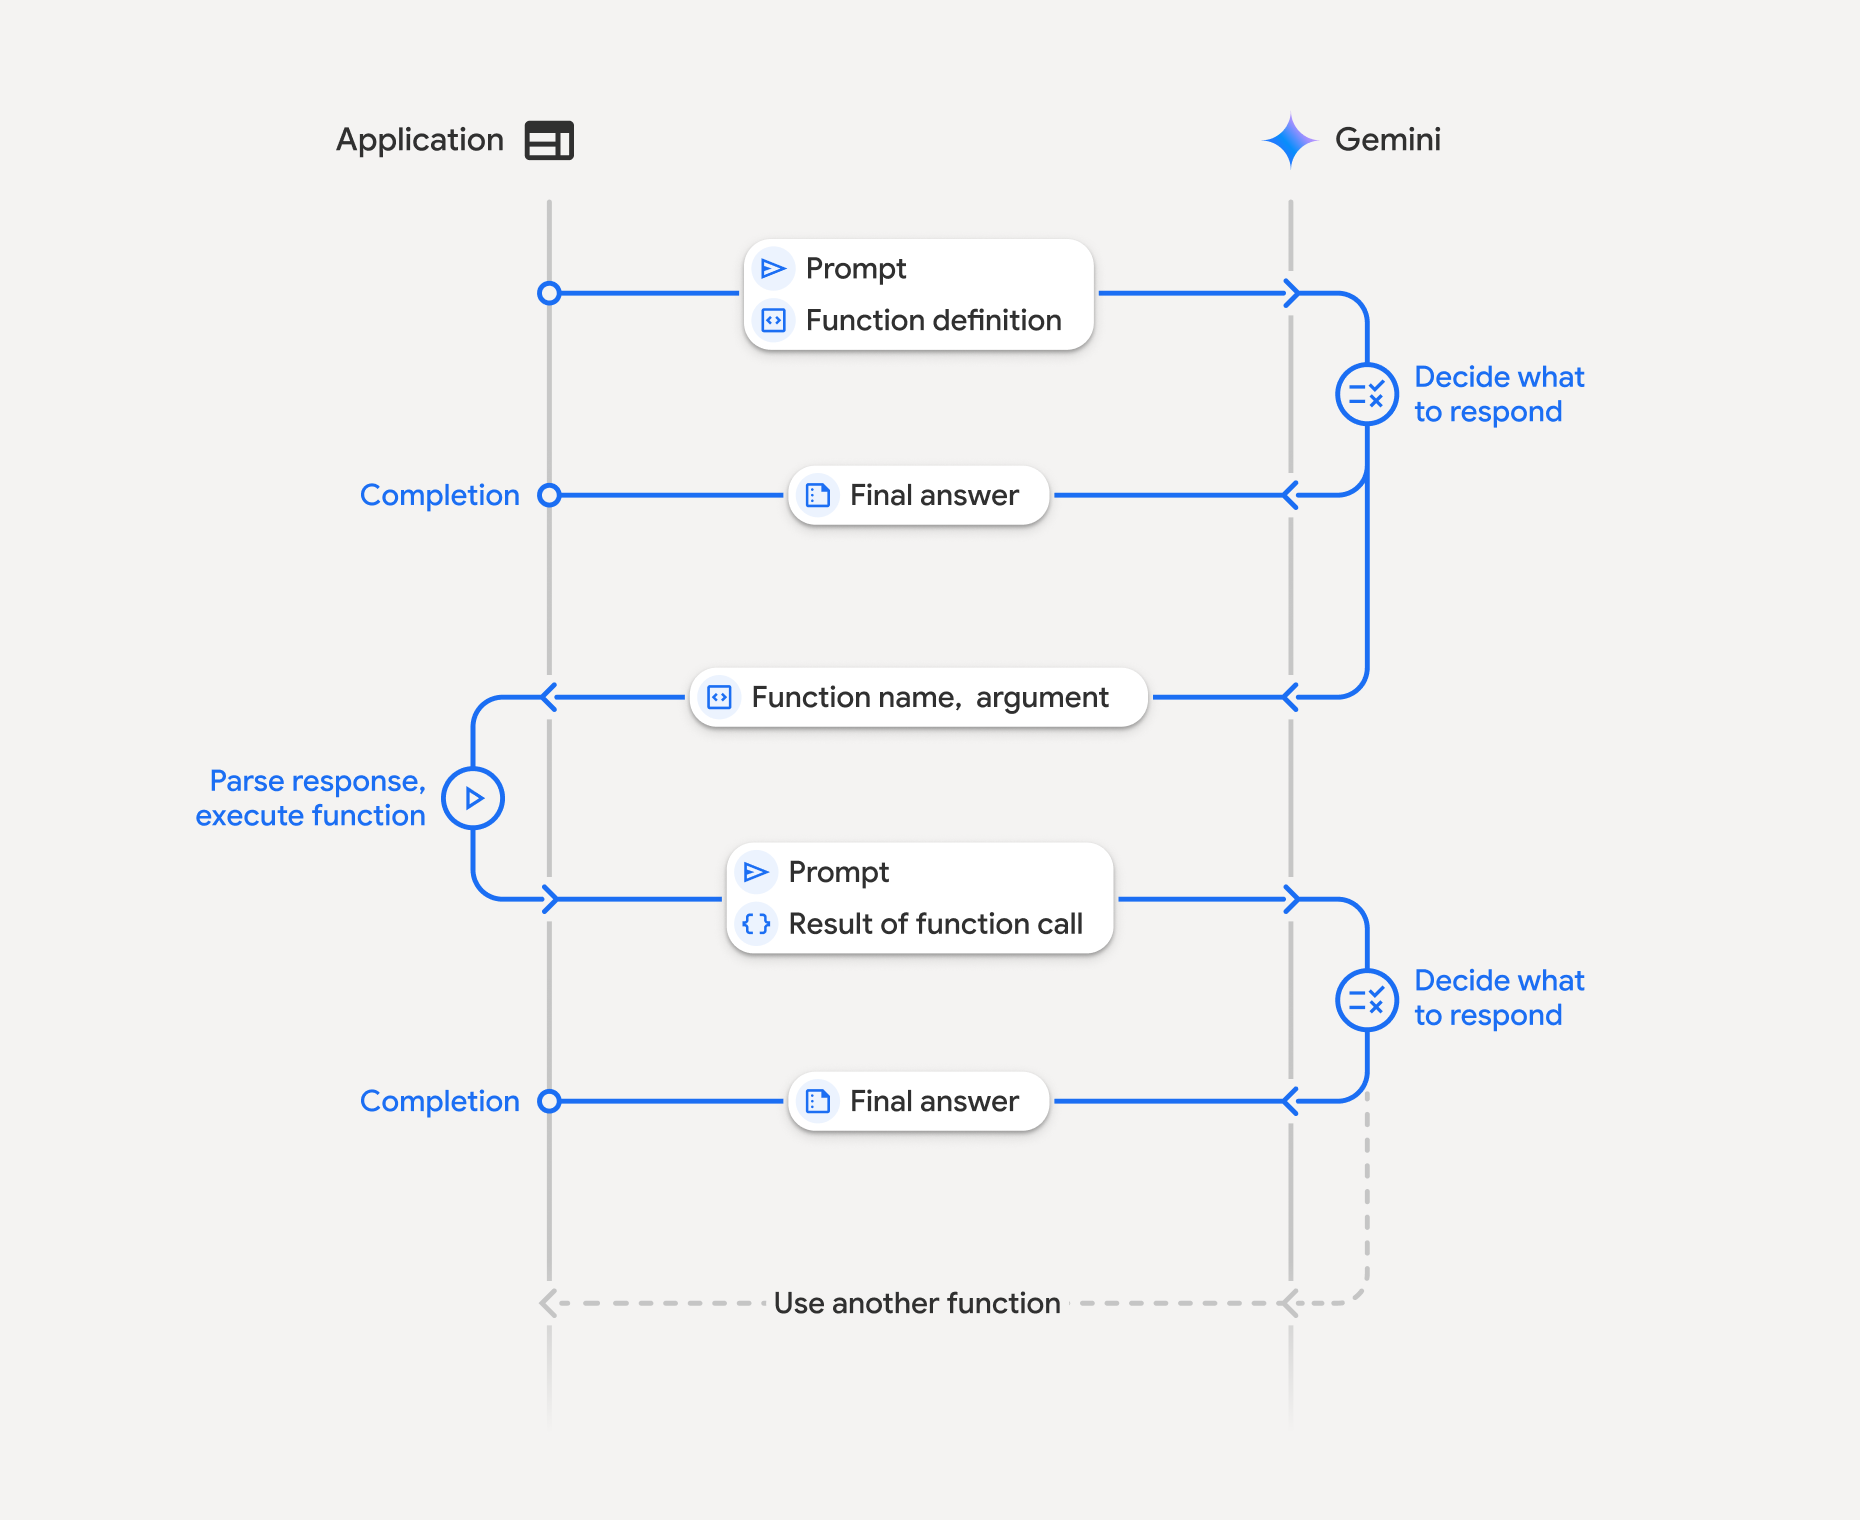

### Step 1: Define Function Declaration

Define a function and its declaration within your application code that allows users to set light values and make an API request. This function could call external services or APIs.

In [ ]:
from google.genai import types

# Define a function that the model can call to parse jo description
markwown_job_parser_declaration = {
    "name": "markwown_job_parser",
    "description": "Analyzes a job description and transforms it into a clear, structured format by highlighting key details, providing explanations, and offering actionable suggestions to help users better understand the job offer.",
    "parameters": {
        "type": "object",
        "properties": {
            "job_desc": {
                "type": "string",
                "description": "The raw job description text that will be used as input. ",
            }
        },
        "required": ["job_desc"],
    },
}

In [ ]:
from typing import Any

# This is the actual function that would be called based on the model's suggestion
def markwown_job_parser(job_desc: str, model=model, tokenizer=tokenizer, alpaca_prompt=alpaca_prompt) -> str:
    """
    Takes a job description, sends it through a language model, and returns the result in markdown format.

    Args:
        job_desc (str): The job description text you want to analyze.
        model (Any): The Unsloth model used to generate structured data.
        tokenizer (Any): The tokenizer from Unsloth to process input and decode output.

    Returns:
        str: A markdown-formatted string with the parsed job information.
    """
    inputs = tokenizer(
        [
            alpaca_prompt.format(
                f"{job_desc}",  # input
                "",             # output
            )
        ],
        return_tensors="pt"
    ).to("cuda")

    # Generate the output from the model
    outputs = model.generate(**inputs, max_new_tokens=1200, use_cache=True)

    # Decode the output tokens into a string
    decoded_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Get only the response part after "### Response:"
    split_text = decoded_text.rsplit("### Response:", 1)
    if len(split_text) > 1:
        response_text = split_text[1].strip()
    else:
        response_text = ""

    # Convert the JSON string into a Python dictionary
    parsed_json = json.loads(response_text)

    # Convert the parsed JSON to markdown format
    markdown_output = parse_job_json_to_md(parsed_json)

    return markdown_output

### Step 2: Call the model with function declarations

Once you have defined your function declarations, you can prompt the model to use the function. It analyzes the prompt and function declarations and decides to respond directly or to call a function. If a function is called the response object will contain a function call suggestion.

In [ ]:
message ="""
Help me understand this job description,
About the job
        Infor Decision Analytics and Science (IDeAS) is a division of Infor that provides AI/ML solutions for various industries. We use advanced predictive and prescriptive analytics to create value-driven solutions. Our goal is to enable fast and effective decision automation for all business functions.

        The Data Science Engineers in IDEAS are the brain behind every data-driven solution. This role relies on a combination of analytics and technical expertise to turn data vision into reality. As a Senior Data Science Engineer, you are responsible for designing, building, and operationalizing large-scale predictive and prescriptive analytics to solve business problems that are important to Infor customers.

        A Day in The Life Typically Includes:
        * Architect, implement, and oversee the end-to-end lifecycle of advanced machine learning solutions, including ML model orchestration, scalable data pipelines, and performance optimization.
        * Develop and enhance ETL/ELT pipelines from diverse customer data sources to ensure alignment with complex ML solution requirements.
        * Drive strategic discussions with business stakeholders to identify critical business challenges and opportunities addressable through AI/ML.
        * Articulate results, insights, and actionable recommendations to executives and cross-functional teams, ensuring alignment with business goals.
        * Lead exploratory data analysis on large, complex, and diverse datasets to evaluate data quality, derive insights, and inform model development.
        * Innovate by designing and delivering cutting-edge AI/ML solutions tailored to specific industry needs, leveraging the latest technologies and frameworks.
        * Mentor and provide technical guidance to junior team members, fostering skill development and ensuring high-quality deliverables across projects.

        Basic Qualifications:
        * Engineering degree (or foreign equivalent) in Mathematical Modeling, Operations Research, Computer Science, Telecommunications, Electrical Engineering, Industrial Engineering, or a related quantitative discipline from an accredited university (or foreign equivalent).
        * Extensive hands-on experience in architecting and deploying end-to-end machine learning and/or optimization pipelines, including ETL processes, data pre-processing, exploratory data analysis, model development, deployment, and production inference.
        * Expert programming skills in Python and strong data-querying expertise in SQL, PySpark, or equivalent frameworks.
        * Proven ability to effectively communicate complex technical concepts and solutions through presentations, technical documentation, blog posts, GitHub projects, and other mediums.
        * Good verbal and written communication skills, with the ability to distill and convey intricate technical topics to diverse audiences, including scientists, engineers, and business leaders.
        * Advanced data modeling and analytical problem-solving skills with a focus on delivering scalable and impactful solutions.
        * Strong collaborative mindset with demonstrated interpersonal skills to lead and contribute effectively to cross-functional teams addressing complex business challenges.
        * Proficiency in analytics and visualization tools such as Tableau, Power BI, or similar platforms, with a track record of creating actionable insights.

        Preferred Qualifications:
        * Advanced degree (Master's or PhD) in Mathematical Modeling, Operations Research, Computer Science, Telecommunications, Electrical Engineering, Industrial Engineering, or a related quantitative discipline from an accredited university (or foreign equivalent).
        * Advanced expertise in machine learning algorithms and hands-on experience with industry-standard frameworks such as TensorFlow, PyTorch, Keras, or equivalent.
        * Demonstrated experience in designing, implementing, and optimizing time series forecasting models and personalized recommendation systems at scale.
        * Proven track record in developing and deploying AI/ML solutions for real-world business problems, including but not limited to demand forecasting, anomaly detection, pricing optimization, and recommendation engines.

        About Infor

        Infor is a global leader in business cloud software products for companies in industry specific markets. Infor builds complete industry suites in the cloud and efficiently deploys technology that puts the user experience first, leverages data science, and integrates easily into existing systems. Over 60,000 organizations worldwide rely on Infor to help overcome market disruptions and achieve business-wide digital transformation.
        For more information visit www.infor.com

        Our Values

        At Infor, we strive for an environment that is founded on a business philosophy called [1] Principle Based Management™ (PBM™) and eight Guiding Principles: integrity, stewardship & compliance, transformation, principled entrepreneurship, knowledge, humility, respect, self-actualization. Increasing diversity is important to reflect our markets, customers, partners, and communities we serve in now and in the future.

        We have a relentless commitment to a culture based on PBM. Informed by the principles that allow a free and open society to flourish, PBM™ prepares individuals to innovate, improve, and transform while fostering a healthy, growing organization that creates long-term value for its clients and supporters and fulfillment for its employees.

        Infor is an Equal Opportunity Employer. We are committed to creating a diverse and inclusive work environment. Infor does not discriminate against candidates or employees because of their sex, race, gender identity, disability, age, sexual orientation, religion, national origin, veteran status, or any other protected status under the law. If you require accommodation or assistance at any time during the application or selection processes, please submit a request by following the directions located in the FAQ section at the bottom of the infor.com/about/careers webpage.

        At Infor we value your privacy that’s why we created a policy that you can read [2] here.


        References

        Visible links
        1. https://www.kochind.com/about/business-philosophy
        2. https://www.infor.com/about/privacy
"""

In [ ]:
from google import genai
from google.colab import userdata

# Generation Config with Function Declaration
tools = types.Tool(function_declarations=[markwown_job_parser_declaration])

# system_message
system_message = "You are a helpful assistant, If a response comes from a function call, return it as-is without modifying or rephrasing it."

# Create the generation configuration with the system instruction
config = types.GenerateContentConfig(
    tools=[tools],
    system_instruction=system_message,
)

# Configure the client
client = genai.Client(api_key=userdata.get('GEMINI_API_KEY'))

# Define user prompt
contents = [
    types.Content(
        role="user", parts=[types.Part(text=message)]
    )
]

# Send request with function declarations
response = client.models.generate_content(
    model="gemini-2.0-flash", config=config, contents=contents
)

The model then returns a functionCall object in an OpenAPI compatible schema specifying how to call one or more of the declared functions in order to respond to the user's question.

In [ ]:
print(response.candidates[0].content.parts[0].function_call)

### Step 3: Execute markwown_job_parser function code
Extract the function call details from the model's response, parse the arguments , and execute the markwown_job_parser function in our code.

In [ ]:
# Extract tool call details
tool_call = response.candidates[0].content.parts[0].function_call

if tool_call.name == "markwown_job_parser":
    result = markwown_job_parser(**tool_call.args)
    print(f"Function execution result: {result}")

### Step 4: Create User friendly response with function result and call the model again
Finally, send the result of the function execution back to the model so it can incorporate this information into its final response to the user.

In [ ]:
# Create a function response part
function_response_part = types.Part.from_function_response(
    name=tool_call.name,
    response={"result": result},
)

# Append function call and result of the function execution to contents
contents.append(types.Content(role="model", parts=[types.Part(function_call=tool_call)])) # Append the model's function call message
contents.append(types.Content(role="user", parts=[function_response_part])) # Append the function response

final_response = client.models.generate_content(
    model="gemini-2.0-flash",
    config=config,
    contents=contents,
)
display(Markdown(final_response.text))

## AI Agent with Llama-4

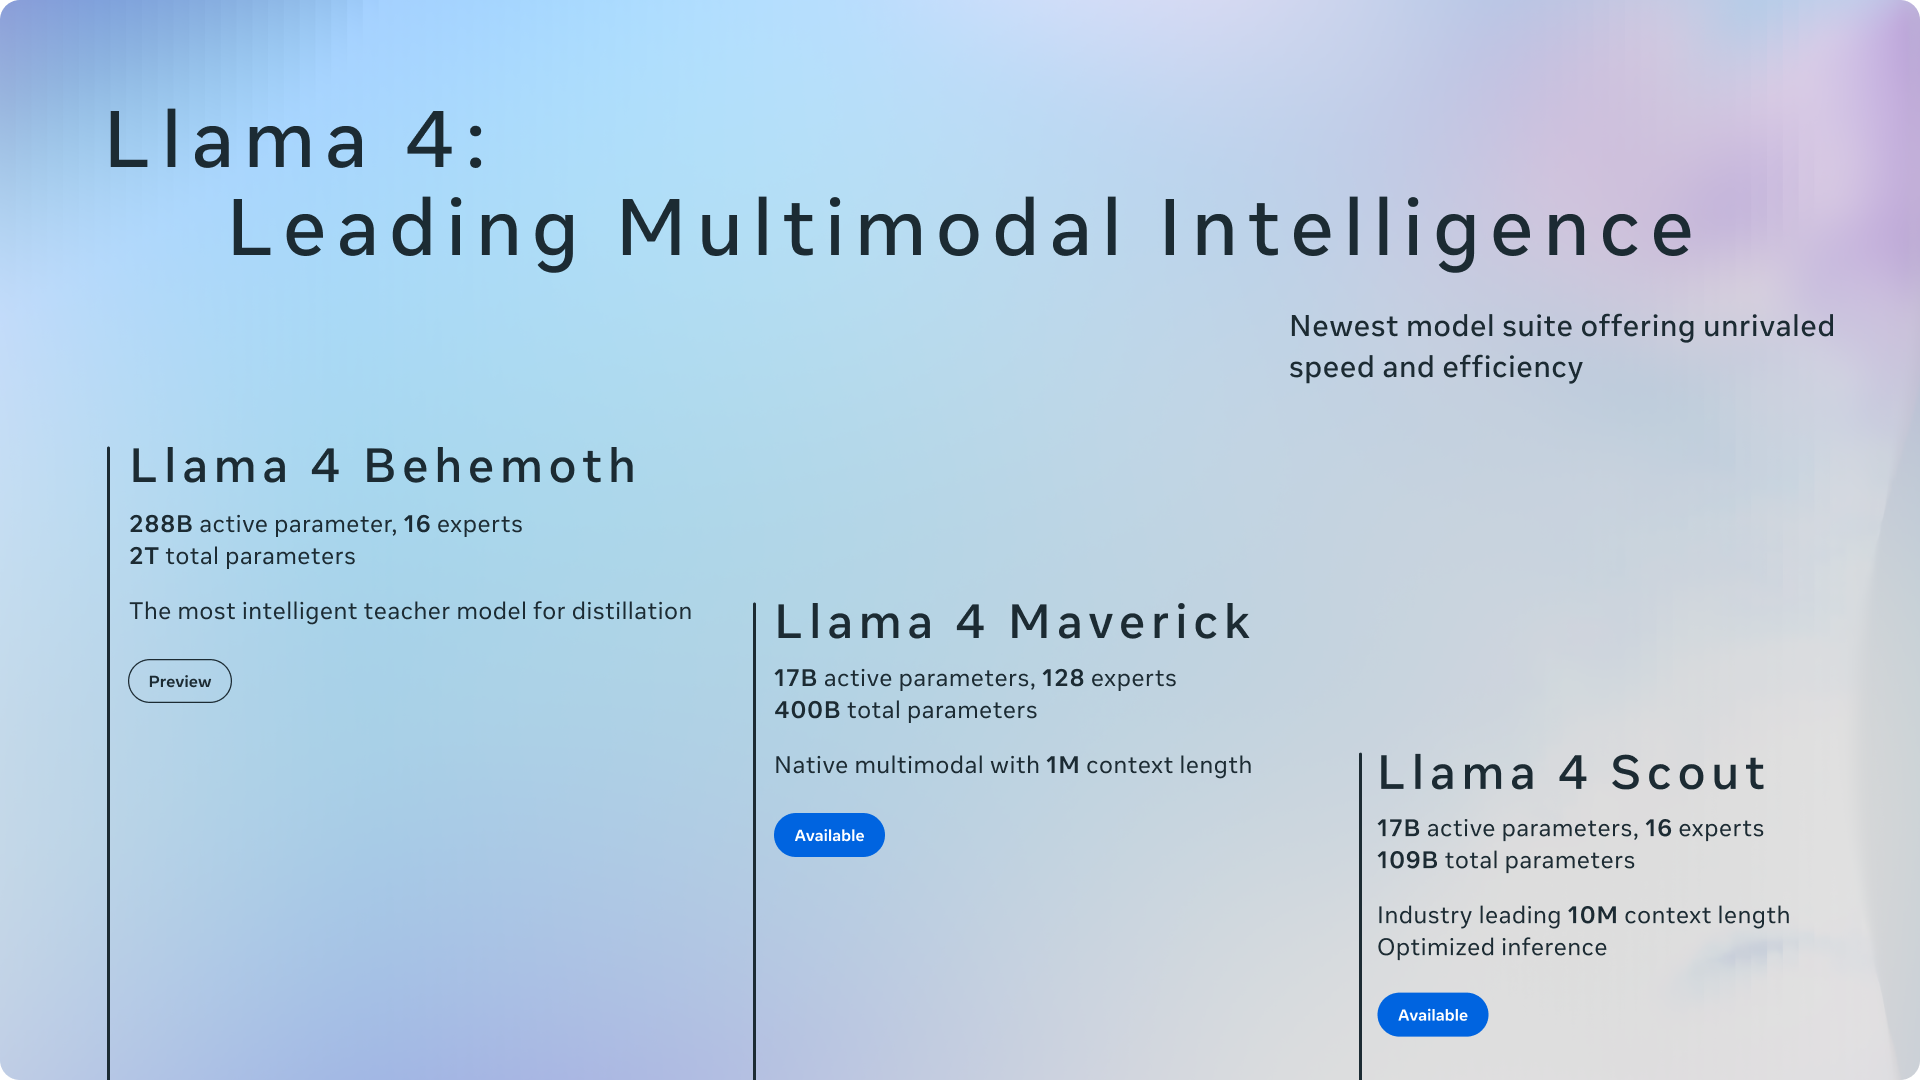

Meta's Llama 4 series introduces two notable AI models: Llama 4 Scout and Llama 4 Maverick. While both models utilize a Mixture of Experts (MoE) architecture for efficient processing, they differ in several key aspects:​



###1. Architecture and Scale:

**Llama 4 Scout:** Incorporates 16 expert modules, activating 17 billion parameters out of a total of 109 billion during inference. This design allows Scout to outperform previous models like Llama 3.3 70B in reasoning tasks, despite its more compact size. ​


**Llama 4 Maverick:** Features 128 expert modules, also activating 17 billion parameters but from a larger total of 400 billion. This extensive architecture enables Maverick to excel in advanced reasoning, coding, and multimodal applications. ​


###2. Performance and Use Cases:

**Llama 4 Scout:** Optimized for long-context reasoning with a context window supporting up to 10 million tokens. It's suitable for tasks requiring extensive context understanding, such as document summarization and complex dialogue systems. ​
Databricks

**Llama 4 Maverick:** Designed for advanced reasoning and multimodal applications, including precise image understanding and multilingual support across 12 languages. It's ideal for creating sophisticated AI applications that bridge language barriers and require nuanced comprehension.

In [ ]:
!pip install groq rich

In [ ]:
job_parser_tool={
    "type": "function",
    "function": {
        "name": "job_parser",
        "description": "Analyzes a job description and transforms it into a clear, structured format by highlighting key details, providing explanations, and offering actionable suggestions to help users better understand the job offer",
        "parameters": {
            "type": "object",
            "properties": {
                "job_desc": {
                    "type": "string",
                    "description": "The raw job description text that will be used as input."
                }
            },
            "required": ["job_desc"]
        }
    }
}

In [ ]:
def job_parser(job_desc: str, model=model, tokenizer=tokenizer, alpaca_prompt=alpaca_prompt) -> str:
    """
    Takes a job description, sends it through a language model, and returns the result in markdown format.

    Args:
        job_desc (str): The job description text you want to analyze.
        model (Any): The Unsloth model used to generate structured data.
        tokenizer (Any): The tokenizer from Unsloth to process input and decode output.

    Returns:
        str: A markdown-formatted string with the parsed job information.
    """
    inputs = tokenizer(
        [
            alpaca_prompt.format(
                f"{job_desc}",  # input
                "",             # output
            )
        ],
        return_tensors="pt"
    ).to("cuda")

    # Generate the output from the model
    outputs = model.generate(**inputs, max_new_tokens=1200, use_cache=True)

    # Decode the output tokens into a string
    decoded_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Get only the response part after "### Response:"
    split_text = decoded_text.rsplit("### Response:", 1)
    if len(split_text) > 1:
        response_text = split_text[1].strip()
    else:
        response_text = ""

    # Convert the JSON string into a Python dictionary
    parsed_json = json.loads(response_text)

    # Convert the parsed JSON to markdown format
    markdown_output = parse_job_json_to_md(parsed_json)

    return markdown_output

In [ ]:
from google.colab import userdata
from groq import Groq

# Initialize the Groq client
groq_api_key = userdata.get('GROQ_API_KEY')
client = Groq(api_key = groq_api_key)

In [ ]:
from rich import print

In [ ]:
history = [
    {
        "role": "system",
        "content": "You are a chat assistant. If the user provides a job description and asks for analysis, summary, or explanation, use the 'job_parser' tool to process it."
    }
]

# Define the available tools (i.e. functions) for our model to use
tools = [job_parser_tool]

# Selecting the model with tool capabilities
# meta-llama/llama-4-scout-17b-16e-instruct
MODEL = "meta-llama/llama-4-scout-17b-16e-instruct"

while True:
    # Get user input
    user_input = input("You: ")

    # Exit the loop if the user types 'exit'
    if user_input.lower() == "exit":
        print("Ending conversation. Goodbye!")
        break

    # Add the user's input to the conversation history
    history.append({"role": "user", "content": user_input})

    # Make the API call to Groq
    response = client.chat.completions.create(
        model=MODEL,
        messages=history,
        stream=False,
        tools=tools,
        tool_choice="auto",
        temperature=0,
        max_tokens=4096
    )

    # Extract the response message and any tool call responses
    response_message = response.choices[0].message
    tool_calls = response_message.tool_calls
    history.append({"role": "assistant", "content": response_message.content})

    # Print the assistant's response
    if response_message.content is not None:
      print(f"[green]Assistant: {response_message.content}[/green]")

    # If the model requested tool calls, handle them
    if tool_calls:
        print("----- Tool call(s) detected. Processing tool requests -----")
        # Define the available functions that can be called by the LLM
        available_functions = {
            "job_parser": job_parser,
        }

        # Process each tool call
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions.get(function_name)

            if function_to_call:
                print(f"----- Calling tool: {function_name} -----")
                function_args = json.loads(tool_call.function.arguments)

                # Call the tool and get the response
                try:
                    function_response = function_to_call(
                        job_desc=function_args.get("job_desc")
                    )
                except Exception as e:
                    print(f"[red]Error executing tool '{function_name}': {e}[/red]")
                    continue

                # Add the tool response to the conversation history
                history.append({
                    "role": "tool",
                    "name": function_name,
                    "content": function_response,
                    "tool_call_id": tool_call.id  # Associate response with the tool call
                })

                # Display the tool's response
                print(f"[blue][{function_name} Tool successfully executed][/blue]")

        # Re-run the model with the updated conversation
        # second_response = client.chat.completions.create(
        #     model=MODEL,
        #     temperature=0,
        #     messages=history
        # )

        # Print the final response from the assistant
        # final_response = second_response.choices[0].message.content


        # We will take the output as is without sending it to the LLM again
        final_response = function_response

        print(f"[green]Assistant: {final_response}[/green]")
        # Update the history with the assistant's final response
        history.append({"role": "assistant", "content": final_response})
